Notebook to generate plots and data for the [data story](https://andreaslp.github.io/APA-DataStory/). 

In [1]:
# Built-in
import os
from IPython.display import display

# Third parties
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn")

In [31]:
# Configuration
DATA_PATH = "data"
PKL_PATH = os.path.join(DATA_PATH, "pkl")
CSV_PATH = os.path.join(DATA_PATH, "csv")
RESOURCES_PATH = os.path.join(DATA_PATH, "resources")

df = pd.read_pickle(os.path.join(PKL_PATH, "final_subset.pkl"))

### 1. Overall look

In [3]:
df.groupby("speaker")["quotation"].count().sort_values(ascending=False).head(10)

speaker
president donald trump    10279
donald trump               7853
president trump            5358
hillary clinton            4644
nancy pelosi               4203
elizabeth warren           3217
lindsey graham             1934
adam schiff                1558
harry reid                 1496
mike pence                 1480
Name: quotation, dtype: int64

In [4]:
df.groupby("parties")["quotation"].count().sort_values(ascending=False)

parties
Republican    56257
Democrat      49672
Name: quotation, dtype: int64

In [5]:
df["compound"].mean()

0.0468416580917407

In [6]:
df.groupby("parties")["compound"].mean()

parties
Democrat      0.049648
Republican    0.044364
Name: compound, dtype: float64

In [12]:
# Most positive
df.iloc[df["compound"].argmax()]["speaker"]

'elizabeth warren'

In [11]:
# Most negative
df.iloc[df["compound"].argmin()]["speaker"]

'kevin mccarthy'

In [107]:
df["date"] = pd.to_datetime(df["date"])

# Global average per month
g_all = df.set_index("date").groupby(pd.Grouper(freq="M"))["compound"].mean()
g_ma = g_all.rolling(5, center=True, closed="both").mean()
# Average per party per month
g = pd.DataFrame(df.set_index("date").groupby([pd.Grouper(freq="M"), "parties"])["compound"].mean()).reset_index("parties")
g_dem = g[g["parties"] == "Democrat"]
g_rep = g[g["parties"] == "Republican"]

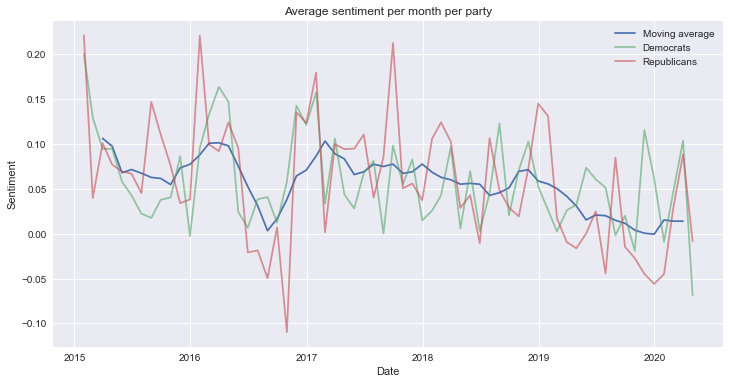

In [116]:
# Plot average score per month and party
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(g_ma.index, g_ma, label="Moving average", alpha=1)
ax.plot(g_dem.index, g_dem["compound"], label="Democrats", alpha=0.6)
ax.plot(g_rep.index, g_rep["compound"], label="Republicans", alpha=0.6)

plt.title("Average sentiment per month per party")
plt.xlabel("Date")
plt.ylabel("Sentiment")

plt.legend()

fname = f"./figures/2.average_month_party.png"
plt.savefig(fname)

plt.show() 

### 3. Impact of key events

In [215]:
events = pd.read_csv(f"{os.path.join(DATA_PATH)}/events/events_weights.csv").drop("Unnamed: 0", axis=1)
# Only include events with weight > 0.5
events = events[events["weight"] > 0.5]

In [218]:
def transform_weight(s, clip=True):
    """
    Return a transformed weight
    """
    if not clip:
        return np.exp(5 ** s) * 0.05
    return np.clip(np.exp(5 ** s) * 0.05, 0, 1)

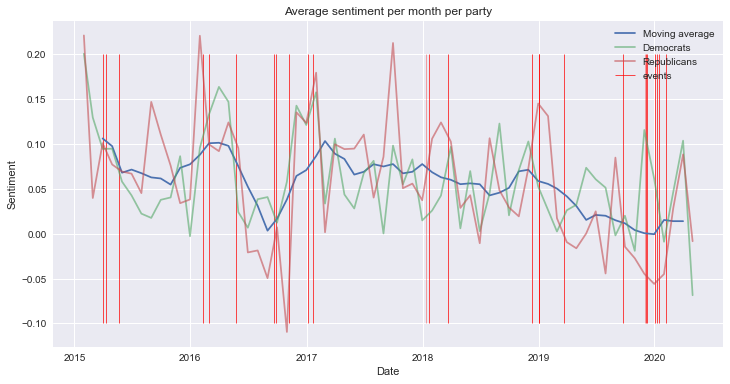

In [219]:
# Redo plot from point 1
df["date"] = pd.to_datetime(df["date"])

# Global average per month
g_all = df.set_index("date").groupby(pd.Grouper(freq="M"))["compound"].mean()
g_ma = g_all.rolling(5, center=True, closed="both").mean()
# Average per party per month
g = pd.DataFrame(df.set_index("date").groupby([pd.Grouper(freq="M"), "parties"])["compound"].mean()).reset_index("parties")
g_dem = g[g["parties"] == "Democrat"]
g_rep = g[g["parties"] == "Republican"]

# Plot average score per month and party
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(g_ma.index, g_ma, label="Moving average", alpha=1)
ax.plot(g_dem.index, g_dem["compound"], label="Democrats", alpha=0.6)
ax.plot(g_rep.index, g_rep["compound"], label="Republicans", alpha=0.6)

# add vertical lines for each event
# To check if we add weight to each event to clearly see more important ones (now random weights)
# clip=False
#ax.vlines(events["date"], ymin=-0.1, ymax=0.2, label="events", colors="red", linestyles="solid", alpha=transform_weight(events["weight"]) * 0.7, linewidth=transform_weight(events["weight"], clip=False))
# clip=True
ax.vlines(events["date"], ymin=-0.1, ymax=0.2, label="events", colors="red", linestyles="solid", alpha=transform_weight(events["weight"]) * 0.7, linewidth=transform_weight(events["weight"], clip=True))


plt.title("Average sentiment per month per party")
plt.xlabel("Date")
plt.ylabel("Sentiment")

plt.legend()

fname = f"./figures/3.5.events_average_month_party.png"
plt.savefig(fname)

plt.show() 

In [213]:
# Add interactivity with plotly